In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import os
import pickle

os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import keras.models as models
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, ZeroPadding2D
import matplotlib.pyplot as plt
import pickle
import keras
import sys
sys.path.append('../confusion')
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, accuracy_score

name = 'CNN2'
filename = "/content/drive/My Drive/RML2016.10a_dict.pkl"
open_file = open(filename,'rb')
Xd= pickle.load(open_file, encoding='latin1')

In [0]:
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):  lbl.append((mod, snr))
X = np.vstack(X)
np.random.seed(2016) 
n_examples = X.shape[0]
n_train = n_examples * 0.5 
train_idx = np.random.choice(range(0, n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0, n_examples)) - set(train_idx)) 
X_train = X[train_idx]
X_test = X[test_idx]

In [7]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1


trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))
# %%
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods
# %%
dr = 0.5  
model = models.Sequential()  
# Reshape [N,2,128] to [N,1,2,128] on input
model.add(Reshape(([1] + in_shp), input_shape=in_shp))
model.add(ZeroPadding2D((0, 2), data_format="channels_first"))
# channels_first corresponds to inputs with shape (batch, channels, height, width).
model.add(Conv2D(256, (1, 3), padding='valid', activation="relu", name="conv1", init='glorot_uniform',
                 data_format="channels_first"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2), data_format="channels_first"))
model.add(Conv2D(80, (2, 3), padding="valid", activation="relu", name="conv2", init='glorot_uniform',
                 data_format="channels_first"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense(len(classes), init='he_normal', name="dense2"))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
# %%

(110000, 2, 128) [2, 128]








/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, name="dense2", kernel_initializer="he_normal")`


In [13]:
epochs = 2  # number of epochs to train on
batch_size = 1024  # training batch size default1024
# %%
filepath = "convmodrecnets_%s_0.5.wts.h5" % (name)  
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(X_test, Y_test),
                    callbacks=[ 
                        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                                        mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ]) 
# Show loss curves

Train on 110000 samples, validate on 110000 samples
Epoch 1/2
 - 709s - loss: 1.8732 - val_loss: 1.7776
Epoch 2/2
 - 710s - loss: 1.7834 - val_loss: 1.6707


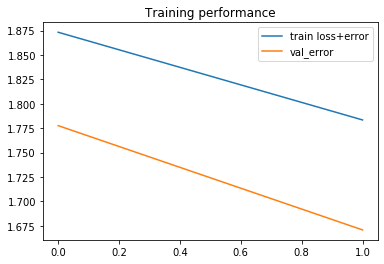

In [14]:
 plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.savefig('%s Training performance' %(name))
# plt.show()


In [17]:
model.load_weights(filepath)
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print('evaluate_score:', score)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title)
    plt.show()

evaluate_score: 1.6707219188256697


In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title)
    # plt.show()


# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)

In [0]:
plt.figure()
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("%s Classification Accuracy on RadioML 2016.10 Alpha" % (name))
plt.savefig("%s Classification Accuracy" % (name))
plt.show()